# NBA Most Valuable Player
## Data Science Final Project

Group Member 1: David Basin
Group Member 2: Mateo Castro
Group Member 3: Abed Islam
***

We will be attempting to determine who will win the NBA Most Valuable Player award using machine learning methods such as SVM/Linear Regression and K-Folds. Our findings will be based on the advanced analystics of past MVP winners, their teams and the advanced analytics of this years players. The datasets to be used are provided.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, linear_model, metrics
%matplotlib inline 

### Part 1: Acquiring and cleaning the data
We will be obtaining and cleaning the data, so that we have only the information we will need for our models.

In [76]:
team_records = pd.read_csv("Standings/Team_Records.csv")
team_records = team_records.loc[team_records["Season"] != "2017-18"]
for i in range(17,22):
    years = str(i)+"-"+str(i+1)
    east_standings = pd.read_csv("Standings/"+years+"_East.csv")
    west_standings = pd.read_csv("Standings/"+years+"_West.csv")
    team_records = pd.concat([team_records,east_standings,west_standings])
team_records["Season"] = team_records["Season"].str.slice(2)
team_records["Team"] = team_records["Team"].str.replace('*','',regex=False)
team_records.set_index(["Season","Team"],inplace=True)
team_dict = {"ATL":"Atlanta Hawks", "BRK":"Brooklyn Nets","BOS":"Boston Celtics","CHO":"Charlotte Hornets",
    "CHI":"Chicago Bulls","CLE":"Cleveland Cavaliers","DAL":"Dallas Mavericks","DEN":"Denver Nuggets",
    "DET":"Detroit Pistons","GSW":"Golden State Warriors","HOU":"Houston Rockets","IND":"Indiana Pacers",
    "LAC":"Los Angeles Clippers","LAL":"Los Angeles Lakers","MEM":"Memphis Grizzlies","MIA":"Miami Heat",
    "MIL":"Milwaukee Bucks","MIN":"Minnesota Timberwolves","NOP":"New Orleans Pelicans","NYK":"New York Knicks",
    "OKC":"Oklahoma City Thunder","ORL":"Orlando Magic","PHI":"Philadelphia 76ers","PHO":"Phoenix Suns",
    "POR":"Portland Trail Blazers","SAC":"Sacramento Kings","SAS":"San Antonio Spurs","TOR":"Toronto Raptors",
    "UTA":"Utah Jazz","WAS":"Washington Wizards","NOJ":"New Orleans Jazz","SEA":"Seattle SuperSonics",
    "WSB":"Washington Bullets","SDC":"San Diego Clippers","KCK":"Kansas City Kings","NJN":"New Jersey Nets",
    "CHH":"Charlotte Hornets","NOH":"New Orleans Hornets","CHA":"Charlotte Bobcats"}
    
total_df = pd.DataFrame()
for i in range(77,121):
    years = str(i)[-2:]+"-"+str(i+1)[-2:]
    voting = pd.read_csv("Voting/"+years+"_Voting.csv", encoding = "ISO-8859-1", engine="python")
    advanced = pd.read_csv("advanced_stats/"+years+"_advanced.csv", encoding = "ISO-8859-1", engine="python")
    pergame = pd.read_csv("PerGame/PerGame_"+years+".csv", encoding = "ISO-8859-1", engine="python")
    #per game: FG%, TRB, AST, STL, BLK, TOV, PTS
    #advanced: PER, TS%, USG%, WS, OBPM, DBPM, VORP
    #Voting: Tm, Share
    voting = voting.loc[:,["Player","Tm","Share"]]
    voting["Winner"] = 0
    voting.at[0,'Winner'] = 1
    advanced = advanced.loc[:,["Player","PER","TS%","USG%","WS","OBPM","DBPM","VORP"]]
    advanced["Player"] = advanced["Player"].str.replace('*','',regex=False)
    pergame = pergame.loc[:,["Player","FG%","TRB","AST","STL","BLK","TOV","PTS"]]
    pergame["Player"] = pergame["Player"].str.replace('*','',regex=False)
    final_df = pd.merge(voting, advanced, how="left", on="Player")
    final_df = pd.merge(final_df, pergame, how="left", on="Player")
    final_df["Year"] = years
    final_df["W/L%"] = 0
    for i, row in final_df.iterrows():
        if row["Tm"] == "TOT": 
            final_df.loc[i,"W/L%"] = .625
        else:
            team = team_dict[row["Tm"]]
            final_df.loc[i,"W/L%"] = team_records.loc[(row["Year"],team)].at["W/L%"]
    share_sum = final_df["Share"].sum()
    final_df["Share"] = final_df["Share"]/final_df["Share"].sum()
    total_df = pd.concat([total_df,final_df])
advanced_22 = pd.read_csv("advanced_stats/21-22_advanced.csv", encoding = "ISO-8859-1", engine="python")
pergame_22 = pd.read_csv("PerGame/PerGame_21-22.csv", encoding = "ISO-8859-1", engine="python")
advanced_22 = advanced_22.loc[:,["Player","Tm","PER","TS%","USG%","WS","OBPM","DBPM","VORP"]]
advanced_22["Player"] = advanced_22["Player"].str.replace('*','',regex=False)
pergame_22 = pergame_22.loc[:,["Player","FG%","TRB","AST","STL","BLK","TOV","PTS"]]
pergame_22["Player"] = pergame_22["Player"].str.replace('*','',regex=False)
final_df_22 = pd.merge(advanced_22, pergame_22, how="left", on="Player")
for i, row in final_df_22.iterrows():
        if row["Tm"] == "TOT": 
            final_df_22.loc[i,"W/L%"] = .625
        else:
            team = team_dict[row["Tm"]]
            final_df_22.loc[i,"W/L%"] = team_records.loc[("21-22",team)].at["W/L%"]

### Part 2: EDA 
In this part, we will be performing Exploratory Data Analysis on the dataset to provide some inital insights to the data.

In [56]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 0 to 14
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  712 non-null    object 
 1   Tm      712 non-null    object 
 2   Share   712 non-null    float64
 3   Winner  712 non-null    int64  
 4   PER     712 non-null    float64
 5   TS%     712 non-null    float64
 6   USG%    712 non-null    float64
 7   WS      712 non-null    float64
 8   OBPM    712 non-null    float64
 9   DBPM    712 non-null    float64
 10  VORP    712 non-null    float64
 11  FG%     712 non-null    float64
 12  TRB     712 non-null    float64
 13  AST     712 non-null    float64
 14  STL     712 non-null    float64
 15  BLK     712 non-null    float64
 16  TOV     712 non-null    float64
 17  PTS     712 non-null    float64
 18  Year    712 non-null    object 
 19  W/L%    712 non-null    float64
dtypes: float64(16), int64(1), object(3)
memory usage: 116.8+ KB


In [55]:
total_df.describe()

,Share,Winner,PER,TS%,USG%,WS,OBPM,DBPM,VORP,FG%,TRB,AST,STL,BLK,TOV,PTS,W/L%
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.00000
mean,0.061798,0.061798,22.518399,0.569487,26.552388,10.572472,4.045365,0.820084,4.703792,0.495080,7.531320,4.992978,1.414747,0.990449,2.895365,22.065871,0.63090
std,0.103275,0.240957,3.781376,0.039809,4.922750,3.347317,2.180080,1.346550,2.085992,0.045546,3.334272,2.803922,0.572574,0.925050,0.690212,5.234622,0.10463
min,0.000383,0.000000,10.100000,0.441000,7.100000,2.200000,-3.100000,-2.400000,0.000000,0.384000,1.900000,0.800000,0.200000,0.000000,0.900000,4.700000,0.22000
25%,0.001537,0.000000,19.900000,0.543000,23.675000,8.400000,2.500000,-0.100000,3.200000,0.463000,4.800000,2.800000,1.000000,0.300000,2.400000,18.800000,0.57300
50%,0.008919,0.000000,22.600000,0.568000,26.700000,10.450000,4.100000,0.750000,4.500000,0.493000,6.900000,4.400000,1.400000,0.700000,2.900000,22.150000,0.64600
75%,0.072930,0.000000,24.900000,0.597250,29.925000,12.725000,5.600000,1.800000,6.000000,0.523000,10.400000,6.700000,1.800000,1.400000,3.300000,25.800000,0.69550
max,0.664336,1.000000,31.900000,0.699000,41.700000,21.200000,10.300000,4.600000,12.500000,0.675000,18.700000,14.500000,3.700000,5.600000,5.700000,37.100000,0.89000


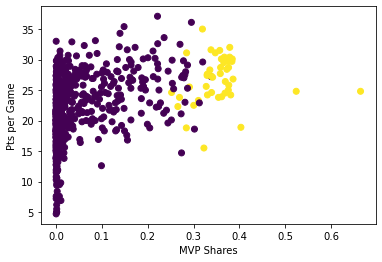

In [61]:
x = total_df["Share"]
y = total_df["PTS"]
plt.xlabel("MVP Shares")
plt.ylabel("Pts per Game")
plt.scatter(x,y, c=total_df["Winner"])
plt.show()

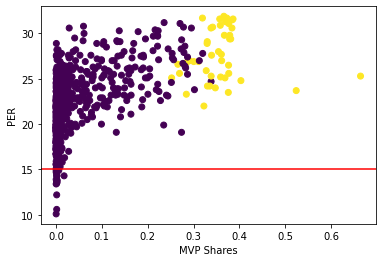

In [62]:
x = total_df["Share"]
y = total_df["PER"]
plt.xlabel("MVP Shares")
plt.ylabel("PER")
plt.scatter(x,y, c=total_df["Winner"])
plt.axhline(y=15, color='r', linestyle='-')
plt.show()

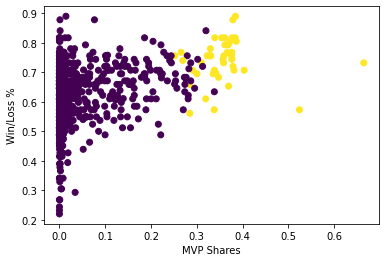

In [63]:
x = total_df["Share"]
y = total_df["W/L%"]
plt.xlabel("MVP Shares")
plt.ylabel("Win/Loss %")
plt.scatter(x,y, c=total_df["Winner"])
plt.show()

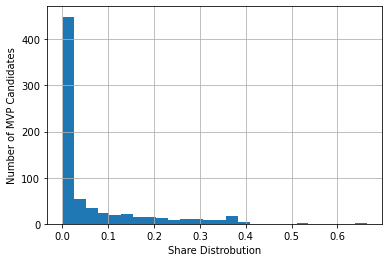

In [64]:
plt.xlabel("Share Distrobution")
plt.ylabel("Number of MVP Candidates")
total_df["Share"].hist(bins=26)
plt.show()

### Part 3: Creating and training the model
Creating the model and training it with the train set.

In [77]:
from sklearn import svm, linear_model, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

model_df = total_df.drop(["Player","Tm","Year"],axis=1)

x_train, x_test, y_train, y_test = train_test_split(model_df.drop("Share",axis=1), 
                                        model_df["Share"], test_size = 0.3, random_state=42)

curr_score = -1
best_c = -1
cs = [10**i for i in range(31)]
for c in cs:
    svr = svm.SVR(C=c)
    svr.fit(x_train,y_train)
    y_pred_svr = svr.predict(x_test)
    score = svr.score(x_train,y_train)
    if curr_score < score:
        best_c = c
print("Best c is: " + "{:e}".format(c))
svr = svm.SVR(C=best_c)
svr.fit(x_train,y_train)
y_pred_svr = svr.predict(x_test)
score = svr.score(x_train,y_train)
print("R-squared:", score)
print("MSE:", mean_squared_error(y_test, y_pred_svr))


Best c is: 1.000000e+30
R-squared: 0.6142067700083076
MSE: 0.009831518863629015


### Part 4: Validating and testing the model
We will optimize the model using K-Folds validation to find the best parameters to use and testing the resulting model.

### Part 5: Determining the MVP
Finally, the MVP will be determined for this season using the model created.

In [78]:
final_df_22.set_index("Player",inplace=True)
final_df_22.drop(["Tm"],axis=1,inplace=True)
final_df_22.dropna(inplace=True)


In [79]:
final_df_22["Share"] = svr.predict(final_df_22)

In [80]:
final_df_22.sort_values(by="Share",ascending=False,inplace=True)
final_df_22.head(10)

,PER,TS%,USG%,WS,OBPM,DBPM,VORP,FG%,TRB,AST,STL,BLK,TOV,PTS,W/L%,Share
Player,,,,,,,,,,,,,,,,
Melvin Frazier,-0.4,0.313,19.5,-0.4,-9.7,-6.7,-0.4,0.271,4.3,0.3,0.3,0.0,1.0,10.7,0.293,0.602117
Nikola JokiÄ,32.8,0.661,31.9,15.2,9.2,4.5,9.8,0.583,13.8,7.9,1.5,0.9,3.8,27.1,0.585,0.421867
Giannis Antetokounmpo,32.1,0.633,34.9,12.9,7.6,3.5,7.4,0.553,11.6,5.8,1.1,1.4,3.3,29.9,0.622,0.319850
Langston Galloway,0.7,0.269,12.8,-0.2,-8.0,-1.8,-0.2,0.231,2.6,1.7,0.1,0.0,0.9,2.0,0.625,0.277671
Collin Sexton,11.2,0.523,27.9,-0.1,-3.5,-0.6,-0.2,0.450,3.3,2.1,0.9,0.0,2.8,16.0,0.537,0.273464
Joel Embiid,31.2,0.616,37.2,12.0,7.2,2.0,6.5,0.499,11.7,4.2,1.1,1.5,3.1,30.6,0.622,0.268774
Dillon Brooks,15.5,0.515,28.8,1.6,-1.0,-0.8,0.0,0.432,3.2,2.8,1.1,0.3,1.6,18.4,0.683,0.250252
Domantas Sabonis,21.9,0.637,22.3,7.1,3.2,0.9,3.2,0.573,12.1,5.2,1.0,0.4,3.1,18.9,0.625,0.226594
Jalen Suggs,8.6,0.455,25.3,-1.6,-5.3,-0.2,-1.2,0.361,3.6,4.4,1.2,0.4,3.0,11.8,0.268,0.199436
